# Random Vector Functional Link (RVFL)

The dataset is also available at: https://github.com/dipuk0506/UQ-Data

## Loading CSV files

In [1]:
train_csv_path = '../input/toy-dataset-for-regression-and-uq/Data7_Train.csv'
test_csv_path = '../input/toy-dataset-for-regression-and-uq/Data7_Test.csv'
val_csv_path = '../input/toy-dataset-for-regression-and-uq/Data7_Val.csv'


import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import imageio
import math


train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
train_df.head()

,Input1,Output
0,-1.000000,-0.373270
1,-0.999733,-0.037757
2,-0.999467,-0.132093
3,-0.999200,-0.184022
4,-0.998933,-0.334794


## Normalizing training and validation data

In [2]:
input_=[]
output_=[]
for row in train_df.iloc:
    input_.append((row[0:len(row)-1]).astype(float))
    output_.append(row[-1])
    
i_val=[]
o_val=[]
for row in val_df.iloc:
    i_val.append((row[0:len(row)-1]).astype(float))
    o_val.append(row[-1])
    
num_input = len(row)-1;
print(num_input)


torch.manual_seed(1)    # reproducible

x = torch.tensor(input_).float()  
y = torch.tensor(output_).float()   
new_shape = (len(y), 1)
y = y.view(new_shape)


i_val = torch.tensor(i_val).float()  
o_val = torch.tensor(o_val).float()   
new_shape = (len(o_val), 1)
o_val = o_val.view(new_shape)



max_y = torch.max(y[:,0])
min_y =torch.min(y[:,0])

max_x = torch.max(x,dim=0)
min_x = torch.min(x,dim=0)

print(max_y, min_y, max_x.values, min_x.values)

range_y = max_y - min_y
range_x = max_x.values - min_x.values

print(range_x, range_y)

    #Normalizing
x = (x - min_x.values)/range_x
y = (y - min_y)/range_y

    #Normalizing
i_val = (i_val - min_x.values)/range_x
o_val = (o_val - min_y)/range_y

1
tensor(1.2477) tensor(-1.2388) tensor([0.9997]) tensor([-1.])
tensor([1.9997]) tensor(2.4865)


## RVFL Network

In [3]:
# torch can only train on Variable, so convert them to Variable
x, y = Variable(x), Variable(y)

# Make RVFL code Here
num_RVFL_HL = 1000
# num_input by num_RVFL_HL sized weight matrix
Const_Weight_RVFL = torch.rand((num_input,num_RVFL_HL))-.5
print(Const_Weight_RVFL.shape)
# num_RVFL_HL by 1 sized hidden bias
Const_bias_RVFL = torch.rand((1,num_RVFL_HL))-.5

print(x.shape)
x2=F.relu(torch.matmul(x,Const_Weight_RVFL) + Const_bias_RVFL)
print(x2.shape)
x_RVFL = torch.cat([x,x2],1)
print(x_RVFL.shape)


i_val2 = F.relu(torch.matmul(i_val,Const_Weight_RVFL) + Const_bias_RVFL)
i_val_RVFL = torch.cat([i_val,i_val2],1)


#Connection to output layer
NN_out = torch.nn.Linear(num_input+num_RVFL_HL, 1)


# use the same net as before      
net = NN_out     # define the network
print(net)  # net architecture
optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

torch.Size([1, 1000])
torch.Size([5000, 1])
torch.Size([5000, 1000])
torch.Size([5000, 1001])
Linear(in_features=1001, out_features=1, bias=True)


## Network Training

In [4]:
#initial values. These values will be replaced with smaller values
minimum_train_loss = 1e5
minimum_val_loss = 1e5
EPOCH = 2000

# start training
for epoch in range(EPOCH):
  
    prediction = net(x_RVFL)     # input x and predict based on x

    loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if loss<minimum_train_loss:
        minimum_train_loss =loss
        net_opt = net
    
    if epoch%200 == 199:
      prediction = net_opt(i_val_RVFL)
      loss_val = loss_func(prediction, o_val)
      if loss_val<minimum_val_loss:
        minimum_val_loss = loss_val
        net_opt_val = net_opt
      print ("Epoch [{}/{}], Loss: {:.4f}, Minimum Loss {:.6f}, Val Loss {:.6f}  "  .format(epoch+1, EPOCH, loss, minimum_train_loss, minimum_val_loss))

Epoch [200/2000], Loss: 0.0398, Minimum Loss 0.039821, Val Loss 0.061555  
Epoch [400/2000], Loss: 0.0267, Minimum Loss 0.026678, Val Loss 0.044833  
Epoch [600/2000], Loss: 0.0181, Minimum Loss 0.018135, Val Loss 0.030207  
Epoch [800/2000], Loss: 0.0129, Minimum Loss 0.012853, Val Loss 0.020644  
Epoch [1000/2000], Loss: 0.0096, Minimum Loss 0.009581, Val Loss 0.014748  
Epoch [1200/2000], Loss: 0.0075, Minimum Loss 0.007510, Val Loss 0.011069  
Epoch [1400/2000], Loss: 0.0062, Minimum Loss 0.006190, Val Loss 0.008723  
Epoch [1600/2000], Loss: 0.0053, Minimum Loss 0.005343, Val Loss 0.007192  
Epoch [1800/2000], Loss: 0.0048, Minimum Loss 0.004786, Val Loss 0.006166  
Epoch [2000/2000], Loss: 0.0044, Minimum Loss 0.004449, Val Loss 0.005526  


## Network on Test Data

In [5]:
test_df = pd.read_csv(test_csv_path)

i_test=[]
o_test=[]
for row in val_df.iloc:
    i_test.append((row[0:len(row)-1]).astype(float))
    o_test.append(row[-1])


   
i_test, o_test = Variable(torch.tensor(i_test)).float(), Variable(torch.tensor(o_test).float())
new_shape = (len(o_test), 1)
o_test = o_test.view(new_shape)

    #Normalizing
i_test = (i_test - min_x.values)/range_x
o_test = (o_test - min_y)/range_y

i_test2 = F.relu(torch.matmul(i_test,Const_Weight_RVFL) + Const_bias_RVFL)
i_test_RVFL = torch.cat([i_test,i_test2],1)
prediction = net_opt_val(i_test_RVFL)

loss_test = loss_func(prediction, o_test)

print("Normalized Test Loss",loss_test.detach().numpy())

loss_test = loss_test*range_y*range_y # As the loss function returns MSE

print("Test Loss",loss_test.detach().numpy())

Normalized Test Loss 0.005525531
Test Loss 0.034162924


## Denormalization

In [6]:
standard_deviation = math.sqrt(minimum_val_loss)
z_95 = 1.96*standard_deviation
LB = prediction.detach().numpy() - z_95
UB = prediction.detach().numpy() + z_95
o_test = o_test.detach().numpy()


#Denormalization
i_test = i_test*range_x + min_x.values
o_test = o_test*range_y.detach().numpy() + min_y.detach().numpy()
LB = LB*range_y.detach().numpy() + min_y.detach().numpy()
UB = UB*range_y.detach().numpy() + min_y.detach().numpy()
prediction = prediction*range_y + min_y

## Plotting

PINAW: 0.2930058795959864   PINC: 0.9545   PINAFD:  0.024747589663753764


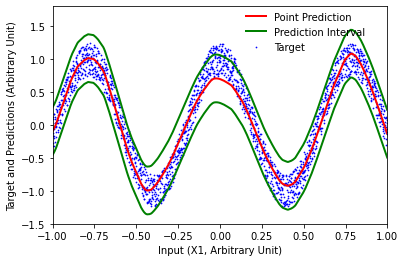

In [7]:
fig, (ax1) = plt.subplots(1, 1)

ax1.set(xlabel="Input (X1, Arbitrary Unit)", ylabel="Target and Predictions (Arbitrary Unit)" , ylim = (-1.5, 1.8), xlim = (-1, 1))
plt.rcParams["figure.figsize"] = (6,5)

ax1.plot(i_test[:,0], prediction.detach().numpy(), color='r', linewidth=2, label='Point Prediction')
ax1.plot(i_test[:,0], LB, color='g', linewidth=2, label='Prediction Interval')
ax1.scatter(i_test[:,0], o_test, color='b',s=.5, label='Target')
ax1.plot(i_test[:,0], UB, linewidth=2, color='g')

leg = ax1.legend(frameon=False, loc='lower left', bbox_to_anchor=(0.55,0.75));

fig.show()




PINAW = np.sum(UB-LB)/len(UB)/(np.max(o_test)-np.min(o_test)) 
# here PINAW= 2*z_95


PINC = 0
PINAFD =0
for iter1 in range(len(UB)):
    if UB[iter1]>=o_test[iter1] and LB[iter1]<=o_test[iter1]:
        PINC = PINC+1
    else:
        PINAFD = PINAFD + np.min([np.abs(UB[iter1]-o_test[iter1]), np.abs(LB[iter1]<o_test[iter1])]) 
        # PINAFD distance from the nearest interval


if PINAFD>0:
    PINAFD = PINAFD/(len(UB) - PINC)/(np.max(o_test)-np.min(o_test))         

PINC = PINC/len(UB)

print("PINAW:",PINAW, "  PINC:", PINC, "  PINAFD: ", PINAFD) 